## Step 1. Data Processing

### 1.1 Loading the Data

In [ ]:
import os

# Change to your desired directory
os.chdir('/common/users/$USER/df_words') # change $USER to netid

# Confirm it's changed
print("Current directory:", os.getcwd())

In [3]:
import pickle

with open('./dfwords_0_20000.pkl', 'rb') as file:
    loaded_dfwords1 = pickle.load(file)

with open('./dfwords_20000_40000.pkl', 'rb') as file:
    loaded_dfwords2 = pickle.load(file)

with open('./dfwords_40000_60000.pkl', 'rb') as file:
    loaded_dfwords3 = pickle.load(file)

with open('./dfwords_60000_80000.pkl', 'rb') as file:
    loaded_dfwords4 = pickle.load(file)

with open('./dfwords_80000_100000.pkl', 'rb') as file:
    loaded_dfwords5 = pickle.load(file)

with open('./dfwords_100000_120000.pkl', 'rb') as file:
    loaded_dfwords6 = pickle.load(file)

with open('./dfwords_120000_140000.pkl', 'rb') as file:
    loaded_dfwords7 = pickle.load(file)

with open('./dfwords_140000_160000.pkl', 'rb') as file:
    loaded_dfwords8 = pickle.load(file)

with open('./dfwords_160000_180000.pkl', 'rb') as file:
    loaded_dfwords9 = pickle.load(file)

with open('./dfwords_180000_200000.pkl', 'rb') as file:
    loaded_dfwords10 = pickle.load(file)

with open('./dfwords_200000_227055.pkl', 'rb') as file:
    loaded_dfwords11 = pickle.load(file)

In [4]:
import pandas as pd

loaded_dfwords = pd.concat([loaded_dfwords1, loaded_dfwords2], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords3], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords4], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords5], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords6], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords7], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords8], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords9], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords10], ignore_index=True)  # vertical stack
loaded_dfwords = pd.concat([loaded_dfwords, loaded_dfwords11], ignore_index=True)  # vertical stack

In [5]:
loaded_dfwords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227055 entries, 0 to 227054
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      227055 non-null  object
 1   text    227055 non-null  object
 2   image   227055 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


### 1.2 Cleaning the Data

In [6]:
import matplotlib.pyplot as plt

def show_image(row):
    plt.imshow(loaded_dfwords.iloc[row,2])
    plt.show()

In [7]:
import re

# Patter for all Special characters
special_char_pattern = r'[^a-zA-Z0-9\s]'  # Matches anything not alphanumeric or whitespace

# Select rows with special characters
special_char_rows = loaded_dfwords[loaded_dfwords['text'].str.contains(special_char_pattern, regex=True, na=False)]

In [8]:
special_char_rows.head()

,id,text,image
1,EHXbhtL,↳,"[[[187, 166, 139], [188, 167, 140], [190, 169,..."
3,EHXbhtL,↳,"[[[180, 161, 134], [181, 162, 135], [184, 163,..."
4,EHXbhtL,.,"[[[189, 167, 142], [189, 167, 142], [189, 167,..."
5,EHXbhtL,-bey,"[[[159, 144, 118], [159, 144, 118], [159, 144,..."
6,EHXbhtL,.,"[[[165, 151, 123], [164, 150, 122], [162, 148,..."


In [9]:
print(special_char_rows.loc[special_char_rows['id'] == 'A3b6IRB',])

            id text                                              image
17743  A3b6IRB   #2  [[[231, 222, 209], [230, 221, 208], [230, 220,...
17747  A3b6IRB   W/  [[[250, 232, 214], [251, 234, 215], [252, 235,...


In [10]:
print(loaded_dfwords.loc[loaded_dfwords['id'] == 'A3b6IRB',])

            id     text                                              image
17742  A3b6IRB  SURGERY  [[[227, 220, 209], [229, 220, 210], [230, 221,...
17743  A3b6IRB       #2  [[[231, 222, 209], [230, 221, 208], [230, 220,...
17744  A3b6IRB     N2O2  [[[249, 235, 213], [248, 234, 212], [248, 234,...
17745  A3b6IRB    CRASH  [[[102, 93, 133], [96, 87, 125], [91, 77, 118]...
17746  A3b6IRB     CART  [[[72, 68, 113], [72, 69, 109], [81, 76, 110],...
17747  A3b6IRB       W/  [[[250, 232, 214], [251, 234, 215], [252, 235,...
17748  A3b6IRB   SHARPS  [[[251, 233, 216], [251, 233, 216], [250, 232,...
17749  A3b6IRB    WHEEL  [[[170, 168, 192], [128, 126, 156], [112, 109,...
17750  A3b6IRB   CHAIRS  [[[245, 230, 214], [243, 227, 214], [242, 226,...
17751  A3b6IRB      SED  [[[121, 117, 154], [113, 109, 149], [103, 100,...
17752  A3b6IRB     ATED  [[[204, 199, 210], [188, 183, 204], [149, 145,...
17753  A3b6IRB  PATIENT  [[[158, 148, 174], [188, 176, 191], [196, 185,...
17754  A3b6IRB     EXIT  

In [11]:
allowed_pattern = r'^[\w\s\.,!?;:\-+*/=()\[\]{}<>@#\$%^&_\'"\t\n]+$'
mask = ~loaded_dfwords['text'].str.contains(allowed_pattern, regex=True)
non_standard_rows = loaded_dfwords[mask]

In [12]:
non_standard_rows.head()

,id,text,image
1,EHXbhtL,↳,"[[[187, 166, 139], [188, 167, 140], [190, 169,..."
3,EHXbhtL,↳,"[[[180, 161, 134], [181, 162, 135], [184, 163,..."
159,fbIRZCU,✓,"[[[178, 171, 162], [178, 171, 162], [178, 171,..."
448,17GNoPL,→,"[[[162, 188, 164], [162, 188, 164], [160, 186,..."
583,duRozwV,€,"[[[107, 107, 116], [109, 109, 118], [113, 115,..."


In [13]:
print(non_standard_rows.loc[non_standard_rows['id'] == 'sNpIWnz',])
print("\n\n\n")
print(non_standard_rows.loc[non_standard_rows['id'] == 'hhk8nvy',])

            id    text                                              image
17848  sNpIWnz    ·USA  [[[10, 9, 18], [9, 9, 18], [8, 10, 18], [10, 1...
17854  sNpIWnz  Japan|  [[[155, 153, 128], [166, 164, 138], [174, 175,...
17855  sNpIWnz  Japan|  [[[150, 153, 127], [128, 131, 106], [159, 162,...




            id          text  \
17949  hhk8nvy  4\/22\/2016.   

                                                   image  
17949  [[[169, 164, 165], [166, 164, 164], [166, 164,...  


In [14]:
mask = loaded_dfwords['text'].str.contains(r'\\', regex=True)
check_rows= loaded_dfwords[mask]

In [15]:
loaded_dfwords['text'] = loaded_dfwords['text'].str.replace('\\/', '/', regex=False)

In [16]:
mask = ~loaded_dfwords['text'].str.contains(allowed_pattern, regex=True)
non_standard_rows2 = loaded_dfwords[mask]

In [17]:
print("Words with special character:", len(non_standard_rows2), ", Percentage: ", len(non_standard_rows2)/len(loaded_dfwords))
print("Images with special charatcer:", len(non_standard_rows2['id'].unique()), ", Percentage: ", len(non_standard_rows2['id'].unique())/len(loaded_dfwords['id'].unique()))

Words with special character: 2004 , Percentage:  0.008826055361035872
Images with special charatcer: 565 , Percentage:  0.07076653306613226


In [18]:
loaded_dfwords=loaded_dfwords[~mask]

In [19]:
print("total number of words", len(loaded_dfwords))
print("total number of images", len(loaded_dfwords['id'].unique()))

total number of words 225051
total number of images 7977


In [20]:
# confirm there is no special characters
count_matching = loaded_dfwords['text'].str.contains(allowed_pattern, regex=True, na=False).sum()
print(f"Number of rows with allowed characters: {count_matching}")

Number of rows with allowed characters: 225051


In [21]:
pattern = r'^[^a-zA-Z0-9]+$'  # Matches strings with no alphanumeric chars at all
non_alnum_rows = loaded_dfwords[loaded_dfwords['text'].str.contains(pattern, regex=True, na=False)]

In [22]:
print("total number of words", len(loaded_dfwords))
print("total number of images", len(loaded_dfwords['id'].unique()))

total number of words 225051
total number of images 7977


In [23]:
non_alnum_rows.head(20)

,id,text,image
4,EHXbhtL,.,"[[[189, 167, 142], [189, 167, 142], [189, 167,..."
6,EHXbhtL,.,"[[[165, 151, 123], [164, 150, 122], [162, 148,..."
7,EHXbhtL,.,"[[[194, 170, 140], [192, 168, 138], [191, 167,..."
46,O91MhJ1,=>,"[[[135, 146, 148], [136, 148, 149], [137, 148,..."
68,O91MhJ1,+,"[[[86, 97, 143], [86, 96, 143], [83, 93, 139],..."
69,O91MhJ1,-,"[[[175, 173, 173], [173, 171, 171], [172, 170,..."
72,O91MhJ1,+,"[[[65, 77, 124], [96, 105, 148], [128, 137, 17..."
73,O91MhJ1,-,"[[[173, 167, 169], [173, 167, 168], [175, 170,..."
74,O91MhJ1,.,"[[[62, 90, 16], [69, 94, 21], [71, 96, 23], [7..."
75,O91MhJ1,.,"[[[65, 87, 14], [69, 92, 18], [67, 92, 16], [5..."


In [24]:
only_period_rows= loaded_dfwords[loaded_dfwords['text'] == '.']

In [25]:
loaded_dfwords = loaded_dfwords[loaded_dfwords['text'] != '.']

In [26]:
print("Words with only one period:", len(only_period_rows), ", Percentage: ", len(only_period_rows)/len(loaded_dfwords))
print("Images with special charatcer:", len(only_period_rows['id'].unique()), ", Percentage: ", len(only_period_rows['id'].unique())/len(loaded_dfwords['id'].unique()))

Words with only one period: 19567 , Percentage:  0.09522395904303985
Images with special charatcer: 3762 , Percentage:  0.48058252427184467


In [27]:
# check other rows that have ony characters
pattern = r'^[^a-zA-Z0-9]+$'  # Matches strings with no alphanumeric chars at all
non_alnum_rows2 = loaded_dfwords[loaded_dfwords['text'].str.contains(pattern, regex=True, na=False)]

In [28]:
non_alnum_rows2.head()

,id,text,image
46,O91MhJ1,=>,"[[[135, 146, 148], [136, 148, 149], [137, 148,..."
68,O91MhJ1,+,"[[[86, 97, 143], [86, 96, 143], [83, 93, 139],..."
69,O91MhJ1,-,"[[[175, 173, 173], [173, 171, 171], [172, 170,..."
72,O91MhJ1,+,"[[[65, 77, 124], [96, 105, 148], [128, 137, 17..."
73,O91MhJ1,-,"[[[173, 167, 169], [173, 167, 168], [175, 170,..."


### 1.3 Splitting the Data into Training and Testing Subsets

In [29]:
import numpy as np

# Get unique groups
unique_images = loaded_dfwords['id'].unique()


# Randomly select 10% for test 
np.random.seed(42)
test_images = np.random.choice(unique_images, 
                              size=int(len(unique_images)*0.2), 
                              replace=False)

In [30]:
test_df = loaded_dfwords[loaded_dfwords['id'].isin(test_images)]
training_df = loaded_dfwords[~loaded_dfwords['id'].isin(test_images)]

In [31]:
print("Words in Train Dataset:", len(training_df), ", Percentage: ", len(training_df)/len(loaded_dfwords))
print("Images in Train Dataset:", len(training_df['id'].unique()), ", Percentage: ", len(training_df['id'].unique())/len(loaded_dfwords['id'].unique()))

Words in Train Dataset: 165084 , Percentage:  0.8033910182787954
Images in Train Dataset: 6263 , Percentage:  0.8000766479305059


In [32]:
print("Words in Test Dataset:", len(test_df), ", Percentage: ", len(test_df)/len(loaded_dfwords))
print("Images in Test Dataset:", len(test_df['id'].unique()), ", Percentage: ", len(test_df['id'].unique())/len(loaded_dfwords['id'].unique()))

Words in Test Dataset: 40400 , Percentage:  0.19660898172120458
Images in Test Dataset: 1565 , Percentage:  0.19992335206949413


In [33]:
print("total number of words", len(loaded_dfwords))
print("total number of images", len(loaded_dfwords['id'].unique()))

total number of words 205484
total number of images 7828


### 1.4 Splitting the Training Data into Training and Validation Subsets

In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, eval_df = train_test_split(training_df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132067 entries, 0 to 132066
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      132067 non-null  object
 1   text    132067 non-null  object
 2   image   132067 non-null  object
dtypes: object(3)
memory usage: 3.0+ MB


In [36]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33017 entries, 0 to 33016
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      33017 non-null  object
 1   text    33017 non-null  object
 2   image   33017 non-null  object
dtypes: object(3)
memory usage: 774.0+ KB


id                                                 Im6dkfT
text                                                   are
image    [[[192, 195, 203], [192, 195, 202], [191, 194,...
Name: 0, dtype: object


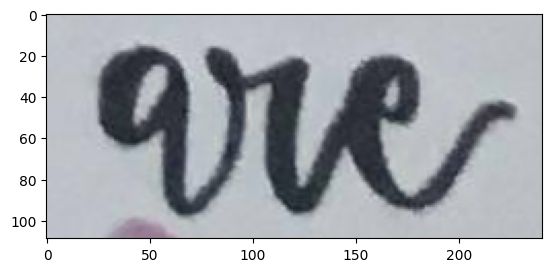

id                                                 9j7E3RC
text                                               Working
image    [[[141, 129, 123], [141, 129, 123], [143, 131,...
Name: 0, dtype: object


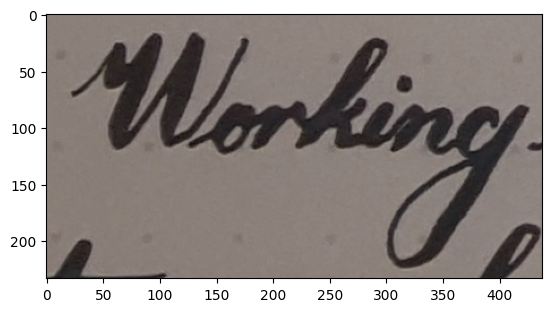

id                                                 7u2pNft
text                                                     4
image    [[[211, 209, 208], [210, 208, 207], [211, 209,...
Name: 0, dtype: object


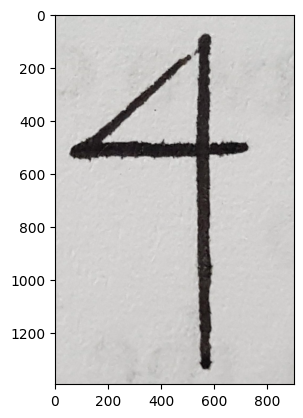

In [37]:
import matplotlib.pyplot as plt

print(train_df.iloc[0])
plt.imshow(train_df.iloc[0,2])
plt.show()

print(eval_df.iloc[0])
plt.imshow(eval_df.iloc[0,2])
plt.show()

print(test_df.iloc[0])
plt.imshow(test_df.iloc[0,2])
plt.show()

### 1.5 Saving the Dataset to CSV

In [38]:
# test_df_copy = test_df
# train_df_copy = training_df

In [221]:
# test_df_copy = test_df_copy.drop('image', axis=1)

In [222]:
# train_df_copy = train_df_copy.drop('image', axis=1)

In [223]:
# test_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40400 entries, 0 to 226963
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      40400 non-null  object
 1   text    40400 non-null  object
dtypes: object(2)
memory usage: 946.9+ KB


In [224]:
# train_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165084 entries, 2 to 227054
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      165084 non-null  object
 1   text    165084 non-null  object
dtypes: object(2)
memory usage: 3.8+ MB


In [246]:
# test_df_copy = test_df_copy.reset_index()
# test_df_copy['word_id'] = test_df_copy.index
# test_df_copy = test_df_copy.drop('index', axis=1)
# test_df_copy = test_df_copy.drop('level_0', axis=1)

# print(test_df_copy)

       word_id       id    text
0            0  7u2pNft       4
1            1  FXwDU08    Funk
2            2  FXwDU08  adelic
3            3  FXwDU08      or
4            4  FXwDU08   Brain
...        ...      ...     ...
40395    40395  3Axsf0I    with
40396    40396  3Axsf0I  anyone
40397    40397  3Axsf0I    else
40398    40398  3Axsf0I    day,
40399    40399  3Axsf0I   neveR

[40400 rows x 3 columns]


In [235]:
# train_df_copy = train_df_copy.reset_index()
# train_df_copy['word_id'] = train_df_copy.index
# train_df_copy = train_df_copy.drop('index', axis=1)
# train_df_copy = train_df_copy.drop('level_0', axis=1)

# print(train_df_copy)

        word_id       id        text
0             0  EHXbhtL          co
1             1  EHXbhtL        -bey
2             2  O91MhJ1    NORTON'S
3             3  O91MhJ1      THEORY
4             4  O91MhJ1           A
...         ...      ...         ...
165079   165079  SPQk0RG     Rather,
165080   165080  SPQk0RG          in
165081   165081  SPQk0RG         his
165082   165082  SPQk0RG  questoning
165083   165083  SPQk0RG          of

[165084 rows x 3 columns]


In [227]:
# train_df_copy = train_df_copy[[train_df_copy.columns[2]] + train_df_copy.columns[:2].tolist()]

In [229]:
# test_df_copy = test_df_copy[[test_df_copy.columns[2]] + test_df_copy.columns[:2].tolist()]

In [241]:
# train_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165084 entries, 0 to 165083
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   word_id  165084 non-null  int64 
 1   id       165084 non-null  object
 2   text     165084 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [242]:
# test_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40400 entries, 0 to 226963
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   word_id  40400 non-null  int64 
 1   id       40400 non-null  object
 2   text     40400 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [249]:
# train_df_copy.head(10)

,word_id,id,text
0,0,EHXbhtL,co
1,1,EHXbhtL,-bey
2,2,O91MhJ1,NORTON'S
3,3,O91MhJ1,THEORY
4,4,O91MhJ1,A
5,5,O91MhJ1,B
6,6,O91MhJ1,LINEAR
7,7,O91MhJ1,CIRCUIT
8,8,O91MhJ1,IN
9,9,O91MhJ1,RN


In [250]:
# test_df_copy.head(10)

,word_id,id,text
0,0,7u2pNft,4
1,1,FXwDU08,Funk
2,2,FXwDU08,adelic
3,3,FXwDU08,or
4,4,FXwDU08,Brain
5,5,FXwDU08,I
6,6,FXwDU08,what
7,7,FXwDU08,I'm
8,8,FXwDU08,"doing,"
9,9,FXwDU08,she


In [251]:
# test_df_copy.to_csv('df_test.csv', index=False)
# train_df_copy.to_csv('df_train.csv', index=False)

## Step 2. Running the Model

### 2.1 Loading the Model

In [39]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [40]:
# get base model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transfor

### 2.2 Splitting the Training Data into Training and Validation Datasets

In [41]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class StyleDataset(Dataset):
    def __init__(self, df, processor, max_target_length=512):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      try:
          text = self.df['text'][idx]
          if not isinstance(text, str) or not text.strip():
              raise ValueError(f"Invalid text at index {idx}: {repr(text)}")
          image_id = self.df['id'][idx]
          try:
              image = self.df['image'][idx]
          except Exception as e:
              raise ValueError(f"Failed to load image for ID {image_id} at index {idx}") from e
          try:
              pixel_values = self.processor(image, return_tensors="pt").pixel_values
          except Exception as e:
              raise ValueError(f"Image processing failed at index {idx}") from e

          if torch.isnan(pixel_values).any() or torch.isinf(pixel_values).any():
              raise ValueError(f"Invalid pixel values (NaN/inf) at index {idx}")
          try:
              labels = self.processor.tokenizer(
                  text,
                  padding="max_length",
                  max_length=self.max_target_length
              ).input_ids
          except Exception as e:
              raise ValueError(f"Tokenization failed for text at index {idx}") from e

          # Replace pad_token_id with -100 for loss masking
          labels = [
              label if label != self.processor.tokenizer.pad_token_id else -100
              for label in labels
          ]
          encoding = {
              "pixel_values": pixel_values.squeeze(),
              "labels": torch.tensor(labels)
          }

          if encoding["pixel_values"].dim() != 3:
              raise ValueError(f"Invalid pixel_values shape at index {idx}")

          if encoding["labels"].numel() != self.max_target_length:
              raise ValueError(f"Labels length mismatch at index {idx}")

          return encoding

      except Exception as e:
          print(f"\nError in sample {idx}:")
          print(f"   Error type: {type(e).__name__}")
          print(f"   Details: {str(e)}")
          if hasattr(e, '__cause__') and e.__cause__:
              print(f"   Underlying error: {type(e.__cause__).__name__}: {str(e.__cause__)}")
          print(f"   DataFrame row:\n{self.df.iloc[idx]}")
          return None

In [42]:
# Tokenized
train_dataset = StyleDataset(df=train_df,processor=processor)
eval_dataset= StyleDataset(df=eval_df,processor=processor)

In [43]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 132067
Number of validation examples: 33017


In [44]:
# get the label string from encoding
def get_label_str(encoding):
  labels = encoding['labels']
  labels[labels == -100] = processor.tokenizer.pad_token_id
  label_str = processor.decode(labels, skip_special_tokens=True)
  return label_str

In [45]:
get_label_str(train_dataset[0])

'are'

id                                                 Im6dkfT
text                                                   are
image    [[[192, 195, 203], [192, 195, 202], [191, 194,...
Name: 0, dtype: object


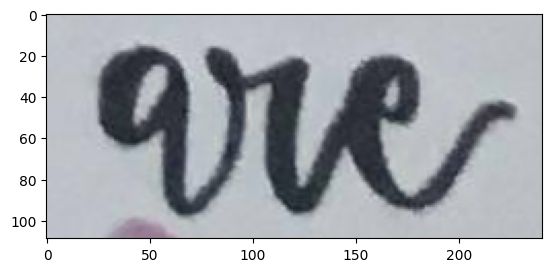

In [46]:
print(train_df.iloc[0])
plt.imshow(train_df.iloc[0,2])
plt.show()

### 2.3 Model Configuration

In [47]:
# Analyze your dataset first
avg_target_len = training_df['text'].apply(len).mean()
print("average target length", avg_target_len)
max_target_len = int(training_df['text'].apply(len).quantile(0.95))
print("maximum target length", max_target_len)

average target length 4.431762012066584
maximum target length 9


In [48]:
# Token Alignment
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = len(processor.tokenizer)

In [49]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    max_length=64,
    early_stopping=True,
    num_beams=4,
    length_penalty=2.0,
    no_repeat_ngram_size=3,
    eos_token_id=processor.tokenizer.sep_token_id,
    decoder_start_token_id=processor.tokenizer.cls_token_id,
    pad_token_id=processor.tokenizer.pad_token_id,
    skip_special_tokens=True  # Added for consistent decoding
)

### 2.4 Metrics

In [50]:
from evaluate import load
cer_metric = load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## Step 3. Fine-tune

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=True,
    output_dir="./output/models/",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=6,
    generation_config=generation_config)

In [ ]:
from transformers import default_data_collator
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    processing_class=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()


/common/home/mx92/Desktop/CS439/myenv/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/common/home/mx92/Desktop/CS439/myenv/lib/python3.10/site-packages/accelerate/accelerator.py:449: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Cer
200,0.810600,3.460251,0.693339
400,0.765800,2.768285,0.880085
600,0.334100,2.733178,0.668167
800,0.192500,2.576872,0.609553
1000,0.320300,2.626310,0.598575
1200,0.901700,3.729049,1.234978
1400,0.575800,3.542256,1.218318
1600,0.891500,3.465171,1.312185
1800,0.429000,3.364644,1.311917
2000,0.356600,3.296528,1.329009


/common/home/mx92/Desktop/CS439/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/common/home/mx92/Desktop/CS439/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
